In [1]:
import os
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
from utils import data_handler
from utils.models import vanilla_autoencoder

In [2]:
%load_ext tensorboard
!rm -rf ../workfiles/logs/


In [11]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session
sgdc_params = {
            #'penalty':["elasticnet", "l1", "l2"],
            'penalty':["l1"],
            #'l1_ratio':np.linspace(0.1, 1, 5),
            'alpha':np.linspace(0.1, 0.5, 5),
        }

x_train, filenames, n_genes = data_handler.generate_dataset(feature_selection_threshold = 2, 
                                                   #feature_selection_proceedure = "LASSO", 
                                                   retain_phases="Both", 
                                                   #retain_phases=None, 
                                                   return_filenames= True,
                                                   sgdc_params = sgdc_params,
                                                   #subsample = 100,
                                                   minimum_time_point = "V08",
                                                   #class_balancing = "match_smaller_sample")
                                                   class_balancing = "balanced")


retaining all patient who have at least passed the Base Line Visit...
matchin_entries ['PPMI-Phase1-IR2.3185.V04.0003156143.5104-SL-1397.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase1-IR2.3619.V08.PP0048-2990.5104-SL-1062.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase2-IR2.3008.V04.0003122858.5104-SL-0980.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase1-IR2.3361.V06.0003166713.5104-SL-0987.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase2-IR2.3661.V02.0003449539.5104-SL-3470.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase2-IR2.3365.V04.0003122891.5104-SL-0252.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase1-IR2.3444.V08.0000309245.5104-SL-1024.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase1-IR2.3653.V06.0003185639.5104-SL-0930.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase1-IR2.4135.V06.0000296623.5104-SL-1272.longRNA-NEBKAP.salmon-gtf.transcripts.sf', 'PPMI-Phase1-IR2.3481.V04.0003288284.5104-SL-0284.longRNA-NEBKAP.salmon-gtf

BL : loaded 4445 samples

V02 : loaded 3200 samples

V04 : loaded 2822 samples

V06 : loaded 2305 samples

V08 : loaded 1585 samples





In [ ]:



#x_train, filenames = data_handler.generate_dataset(feature_selection_threshold = 5, retain_phases="2", return_filenames= True, batch_size = 128)

sgdc_params = {
            #'penalty':["elasticnet", "l1", "l2"],
            'penalty':["l1"], # LASSO selection
            #'l1_ratio':np.linspace(0.1, 1, 5),
            'alpha':np.linspace(0.1, 0.5, 5),
        }

x_train, filenames, n_genes = data_handler.generate_dataset(feature_selection_threshold = None, 
                                                   feature_selection_proceedure = "LASSO", 
                                                   retain_phases="2", 
                                                   return_filenames= True,
                                                   sgdc_params = sgdc_params)

best estimator: SGDClassifier(alpha=0.2, loss='log', penalty='l1')


In [8]:
latent_dim = 256

t_shape = (n_genes)


autoencoder = vanilla_autoencoder.generate_model(t_shape, latent_dim)
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [9]:
checkpoint_filepath = '../workfiles/simple_ae/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=15, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=30)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

In [5]:
%tensorboard --logdir ../workfiles/logs/fit


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

In [10]:
hist = autoencoder.fit(x_train, epochs=2000, callbacks=cb)

Epoch 1/2000


2023-07-27 17:36:32.129393: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


46/46 [==============================] - 10s 202ms/step - loss: 340292.8477 - lr: 0.0010
Epoch 2/2000
46/46 [==============================] - 8s 168ms/step - loss: 75662.5450 - lr: 0.0010
Epoch 3/2000
46/46 [==============================] - 7s 156ms/step - loss: 25646.4426 - lr: 0.0010
Epoch 4/2000
46/46 [==============================] - 7s 162ms/step - loss: 19307.8517 - lr: 0.0010
Epoch 5/2000
46/46 [==============================] - 7s 161ms/step - loss: 17675.1797 - lr: 0.0010
Epoch 6/2000
46/46 [==============================] - 7s 159ms/step - loss: 14574.2445 - lr: 0.0010
Epoch 7/2000
46/46 [==============================] - 8s 167ms/step - loss: 11794.2449 - lr: 0.0010
Epoch 8/2000
46/46 [==============================] - 8s 166ms/step - loss: 9758.9948 - lr: 0.0010
Epoch 9/2000
46/46 [==============================] - 8s 165ms/step - loss: 9647.8767 - lr: 0.0010
Epoch 10/2000
46/46 [==============================] - 8s 165ms/step - loss: 8316.3592 - lr: 0.0010
Epoch 11/2000

In [11]:
autoencoder.load_weights(checkpoint_filepath)


[220389.453125, 60308.90234375, 23743.38671875, 18886.17578125, 16952.01171875, 14150.435546875, 11229.7734375, 9723.84765625, 9487.87109375, 7809.15087890625, 7425.6875, 7370.869140625, 10685.736328125, 15351.162109375, 8973.58984375, 5778.39990234375, 4933.22509765625, 4929.56103515625, 4815.30419921875, 5017.931640625, 4820.21337890625, 4689.9755859375, 4961.58837890625, 4704.00390625, 4621.70556640625, 4403.60546875, 4783.623046875, 4595.12890625, 5102.8134765625, 4856.09423828125, 3914.74365234375, 3490.114013671875, 3153.606689453125, 8951.63671875, 8084.0615234375, 5374.7890625, 4088.7333984375, 3322.129150390625, 3250.933349609375, 3815.701171875, 3944.377197265625, 3027.986328125, 3090.75341796875, 3670.658935546875, 3874.4609375, 3187.38720703125, 3060.00537109375, 5002.13671875, 4316.2255859375, 7029.74072265625, 5754.39111328125, 4107.650390625, 3194.66796875, 2665.915283203125, 2728.192626953125, 2929.020751953125, 2638.195556640625, 2606.048583984375, 2476.029052734375, 2

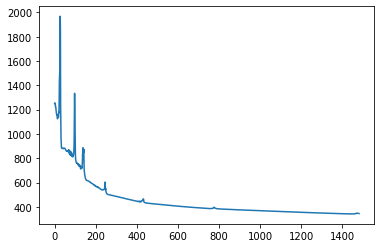

In [16]:
plt.plot(hist.history['loss'][100:])
print(hist.history['loss'])




### some diagnosis

In [17]:
e = iter(x_train).next()
z = autoencoder.encoder(e)
z

<tf.Tensor: shape=(64, 256), dtype=float32, numpy=
array([[  891.12476 ,  -199.0619  ,  -185.20244 , ...,   -77.88834 ,
          386.2135  , -1215.6223  ],
       [  302.38376 ,   102.91805 ,   333.95792 , ...,   170.61308 ,
          -37.2038  , -1082.74    ],
       [  947.41907 ,  -428.49918 ,  -276.06244 , ...,   897.25525 ,
          285.6234  , -1920.3047  ],
       ...,
       [  213.40372 ,   261.1188  ,   163.45633 , ...,   -28.388071,
          -22.475477, -1440.7051  ],
       [ -345.8226  ,  -226.84099 ,  -237.19608 , ...,   -54.970398,
           40.746773, -1251.0425  ],
       [  635.4123  ,   -54.406433,   -45.71511 , ...,   -40.395058,
           26.923763, -1132.6377  ]], dtype=float32)>

In [18]:
print(autoencoder.decoder(z))
print(e)

tf.Tensor(
[[ 13.760094   -6.5564175   4.270477  ...  85.16937   166.56357
   82.149155 ]
 [ 55.219936   57.387012   11.096862  ... 442.98477   829.817
  394.5562   ]
 [  6.42833    89.61059     8.378219  ...  28.421743   22.297655
   68.658806 ]
 ...
 [  7.887551   56.56641    11.503229  ...  29.658817    4.830568
   60.172073 ]
 [ 34.919155  129.75276    10.217013  ... 174.65004   279.03076
  187.13231  ]
 [ 31.946598   -3.1494846  17.116308  ... 171.45898    53.88695
  309.9056   ]], shape=(64, 14868), dtype=float32)
tf.Tensor(
[[  6.55631  28.0786    6.12944 ...  21.601    14.5302   43.2891 ]
 [ 56.9107   56.2618   12.0774  ... 346.531   649.73    311.662  ]
 [  7.04612  69.99      8.48491 ...  45.6259   32.0575   60.2416 ]
 ...
 [  4.37231  69.9861   12.1402  ...  58.334    83.0469   90.6189 ]
 [ 31.2604   92.6      10.9194  ... 179.598   269.233   192.877  ]
 [ 21.9774   32.9183   17.4648  ... 177.784    76.9843  343.017  ]], shape=(64, 14868), dtype=float32)


In [19]:
autoencoder.encoder.save('../workfiles/simple_ae')


INFO:tensorflow:Assets written to: ../workfiles/simple_ae/assets


In [20]:
compressed_dataframe = autoencoder.encoder.predict(x_train)

46/46 [==============================] - 1s 10ms/step


In [21]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [22]:
df.to_csv("../workfiles/processed_data.csv", index=False)
